# Methodology
**Objective:** Train a machine learning model that can tell us which _Which Is English?_ items to present to a test-taker and in what order so that we can determine their English proficiency score.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from joblib import dump, load
from scipy.stats import linregress
from sklearn.metrics import max_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from surprise.dataset import Dataset
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.reader import Reader

# Set random state
random_state = 14 # My wife's favorite number!

# Create cache folder for large, generated files
if not os.path.exists('cached'):
    os.makedirs('cached')

## Data preprocessing

### Cull first encounters
Let's begin by pulling in our first encounters data.

In [2]:
# Read in the first encounters data
df_fe = pd.read_csv('data/first_encounters.csv', encoding='utf-8', index_col='ordinal')

C:\Users\emq\anaconda3\envs\wie\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Our first step will be to cull the data, so that we're left only with users and items that have a significant amount of interactions.

In [3]:
# Get user encounter counts
user_encounter_counts = df_fe.groupby('user_id')['correct_response'].count()
user_encounter_counts.describe()

count    85802.000000
mean        97.347078
std        522.900077
min          1.000000
25%         14.000000
50%         24.000000
75%         54.000000
max      17944.000000
Name: correct_response, dtype: float64

The 25th percentile encountered 14 items or fewer; the 50th percentile encountered 24 items or fewer. A game of _Which Is English?_ is usually about 14 items, so those folks beneath the 25th percentile only played one game. Ideally, we want users who played more than that, and also, we'd like to limit our data to a manageable size. Let's put our threshold, then, at the 50th percentile.

In [4]:
# Cull significant users
user_sig = user_encounter_counts[user_encounter_counts > user_encounter_counts.quantile(0.5)]

Now let's select only items that have a history with our "significant" users.

In [5]:
# Cull items that interacted with significant users
item_encounter_counts = df_fe[df_fe['user_id'].isin(user_sig.index)].groupby('item_id')['correct_response'].count()
item_encounter_counts.describe()

count    18081.000000
mean       432.402854
std        250.696392
min          1.000000
25%        256.000000
50%        348.000000
75%        612.000000
max       1562.000000
Name: correct_response, dtype: float64

The 25th percentile has plenty of interactions, so we'll use that as our threshold.

In [6]:
# Cull significant items
item_sig = item_encounter_counts[item_encounter_counts > item_encounter_counts.quantile(0.25)]

# How many users and items are we left with?
print(f'users: {user_sig.shape[0]}', f'items: {item_sig.shape[0]}')

users: 42200 items: 13517


### Fill in sparse data
#### Perform SVD
We already know that our data is sparse; not every user has interacted with every item. If we're planning to use machine learning to make predictions, we're going to have to fill in our matrix. [Funk SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) has the amazing ability to fill sparse user-item interaction data like ours with predictions, so let's try it out!

**Although Funk SVD is normally used to predict user ratings on items, I'm choosing to view correct and incorrect answers as "ratings" of items. Theoretically, predictions should reflect a user's likelihood to get an item correct. This is the "big trick" I've come up with to avoid using more traditional [computerized adaptive testing](https://en.wikipedia.org/wiki/Computerized_adaptive_testing) techniques (which would be the fallback approach if this one doesn't work).**

We're using [Surprise](http://surpriselib.com/) for this, so first we need to create a trainset from our first encounters, fit the SVD algorithm with the trainset, then reconstruct the matrix from the resulting factorizations.

_NOTE: For operations that create large artifacts, I try to load cached versions before recreating them from scratch._

In [7]:
# Make trainset
cached_trainset_path = 'cached/trainset.joblib'
try:
    # Load trainset
    trainset = load(cached_trainset_path)
except:
    # Build data reader with binary "rating scale" representing wrong and right answers
    reader = Reader(rating_scale=(0, 1))
    
    # Build trainset from significant users and items
    trainset = Dataset.load_from_df(
        df_fe[(df_fe['user_id'].isin(user_sig.index)) & (df_fe['item_id'].isin(item_sig.index))],
        reader).build_full_trainset()
    
    # Save trainset
    dump(trainset, cached_trainset_path)

In [8]:
# Perform SVD
cached_svd_path = 'cached/svd.joblib'
try:
    # Load trained SVD object
    svd = load(cached_svd_path)
except:
    # Train SVD algorithm with the default 100 factors and 20 epochs
    svd = SVD(random_state=random_state).fit(trainset)
    
    # Save trained SVD object
    dump(svd, cached_svd_path)

#### Normalize the item biases
In the [Exploration](Exploration.ipynb#testings_testitem) notebook, I noted that the `est_rating` field of the `testings_testitem` SQL table was populated with ratings that indicated relative (not absolute) item difficulty that could not always be trusted. An exciting byproduct of SVD is the bias it generates for every item (and user), effectively providing us with a mathematically justifiable, absolute alternative! **We can interpret an item's bias as the "easiness" of that item, as a higher bias means a given user is more likely to answer it correctly.**

So now it's time for another sanity check: the item biases should theoretically correlate with the estimated ratings.

correlation: 0.9681455049433862


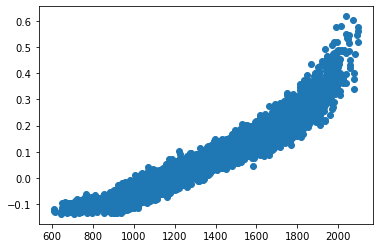

In [9]:
# Get axis labels for the trainset
user_ids = [trainset.to_raw_uid(user) for user in trainset.all_users()]
item_ids = [trainset.to_raw_iid(item) for item in trainset.all_items()]

# Associate item ids with item biases
item_biases = pd.Series(svd.bi, index=item_ids, name='item_bias')

# Get estimated ratings
df_est_ratings = pd.read_csv('data/testitem_active_est_rating.csv', encoding='utf-8', index_col='id')

# Do inverted item biases correlate positively with estimated ratings?
df_biases_ratings = df_est_ratings.merge(item_biases, left_index=True, right_index=True)
x_rating = df_biases_ratings['est_rating']
y_bias = -df_biases_ratings['item_bias']
print(f'correlation: {np.corrcoef(x_rating, y_bias)[0, 1]}')
plt.scatter(x_rating, y_bias)

Hey! Not bad! To me, this is strong evidence in favor of the conjecture that item biases generated from SVD can be used as a measure of item difficulty. With that shown, let's reconstruct the data and get our answer predictions!

#### Reconstruct the data
This was tricky for me! [The formula for reconstructing a prediction](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) is $\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$, where:

- $\mu$ is the global mean
- $b_u$ is the user bias
- $b_i$ is the item bias
- $q_i^T$ is the factored item matrix, transposed
- $p_u$ is the factored user matrix

At first, I reconstructed the data without adding the global mean. That threw everything off, and I despaired until I realized my mistake! Anyway, let's construct it the right way now.

In [10]:
# Construct matrix data
def construct_matrix_data(svd, trainset):
    # Assemble variables
    index = user_ids
    columns = item_ids
    global_mean = trainset.global_mean
    bu = np.array([svd.bu]).transpose()
    bi = svd.bi
    qi_T = svd.qi.transpose()
    pu = svd.pu
    
    # Construct dataframe
    df_md = pd.DataFrame(
        global_mean + bu + bi + np.dot(pu, qi_T),
        index=user_ids,
        columns=item_ids).clip(0, 1) # Clip to possible percent values
    return df_md

cached_matrix_data_path = 'cached/matrix_data.joblib'
try:
    # Load trained SVD object
    df_md = load(cached_matrix_data_path)
except:
    # Construct the matrix data
    df_md = construct_matrix_data(svd, trainset)
    
    # Save the matrix data
    dump(df_md, cached_matrix_data_path)

### Create training data
#### Determine user scores
We already know the inputs to our machine learning model will be based on our matrix data, which represents the users' chances of answering items correctly. However, we don't know our outputs. What is a user's "score"? How do we get it?

In my early work, I attempted to use the user biases generated by SVD as the output. It seemed perfect, because I'd been handed a set of numbers that represented each user's general ability to answer items correctly, and that's essentially what I want for my model output. Here's what the user biases look like:

(array([5.2000e+01, 1.0000e+01, 1.1000e+01, 7.8000e+01, 2.9600e+02,
        1.6190e+03, 9.9480e+03, 1.9971e+04, 9.3280e+03, 8.8700e+02]),
 array([-0.94839306, -0.82299685, -0.69760064, -0.57220443, -0.44680822,
        -0.32141201, -0.1960158 , -0.0706196 ,  0.05477661,  0.18017282,
         0.30556903]),
 <a list of 10 Patch objects>)

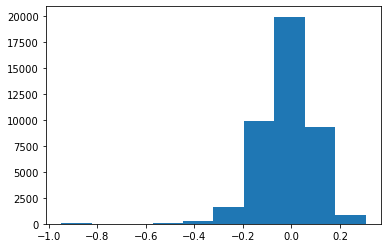

In [11]:
plt.hist(svd.bu)

This looks a lot like the average percent correct by user, which we saw in [the Users section of the Exploration notebook](Exploration.ipynb#Users). However, recall that there's a natural bias in our data toward answering questions correctly, since _Which Is English?_ attempts to challenge players at their level. It makes sense, then, that our mean would be high. At first, I attempted to compensate for this by clipping the data to $\mu \pm 3\sigma$. But then I realized two things:
- There may be a difference between a user's average ability to answer correctly and their ability score. For my purposes, I wanted the ability score.
- Clipping the data is an artificial means of determining the minimum and maximum score. Was there a more natural way I could do this?

So instead of using user biases, let's try to **find the item bias at which each user's chance of answering correctly falls below a given threshold.** That may give us an alternate way to determine a user's score that solves the problems listed above.

Since classic [item response theory places a user's ability at the half-way point between the guessing chance and one](https://en.wikipedia.org/wiki/Item_response_theory#The_item_response_function), I figured $(1.0 - 0.5) / 2 + 0.5 = 0.75$ would be a good threshold to choose. So let's take a look at a sample of user guessing chances plotted against item biases with that threshold specially marked.

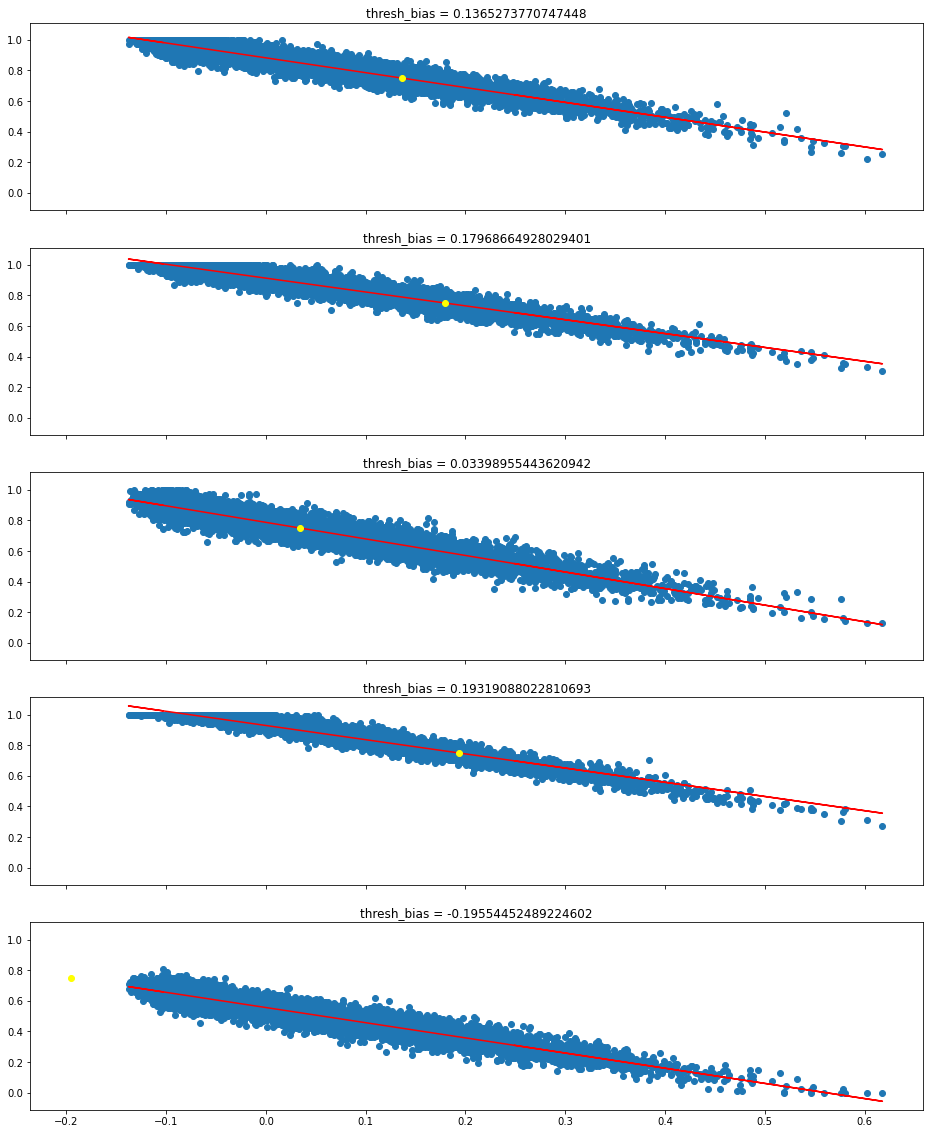

In [12]:
# Set threshold
threshold = 0.75

# Get sample user ids
sample_size = 5
user_sample_ids = np.random.choice(user_ids, sample_size)

# Create subplots
fig, axs = plt.subplots(sample_size, figsize=(16, 4 * sample_size), sharex=True, sharey=True)
i = 0
for label, data in df_md.loc[user_sample_ids].iterrows():
    # Plot correct chance againt item bias
    axs[i].scatter(-svd.bi, data)
    
    # Plot line of best fit
    line = linregress(-svd.bi, data)
    axs[i].plot(-svd.bi, line.slope * -svd.bi + line.intercept, color='red')
    
    # Show item bias at threshold
    thresh_bias = (threshold - line.intercept) / line.slope
    axs[i].plot(thresh_bias, threshold, marker='o', color='yellow')
    axs[i].set_title(f'thresh_bias = {thresh_bias}')
    
    # Increment subplot index
    i += 1

Above, the yellow dot indicates the item difficulty (expressed in terms of SVD item bias) at which the user is estimated to have a 75% chance of getting the correct answer. Notice that sometimes, the yellow dot may fall well outside the range of item biases; this means that, in our scoring system, the user would get an extreme score (either the minimum or the maximum). That's good! It means the extremes of our scale will not be reserved for the worst or best testers ever, but rather can be achieved naturally by any user who is either _mostly guessing_ or _mostly not guessing_ at the entire pool of test items.

_NOTE: Notice I didn't clip the estimated correct answer chances to a minimum of 0.5, the pure guessing chance. I did this in order to facilitate fitting a line to the data. Later, when we train our model, we'll clip the inputs to a minimum of 0.5. When we test actual users, after all, that will be the real minimum chance they have to answer a question correctly._

Now that we have the definition of a score, we'll calculate it for every user. **As an additional step, we'll normalize the item biases to a desired range. That range will be $[20, 120]$ to avoid giving anyone a score of zero, which is a real downer. Then we'll limit user scores to that same range.**

count    42200.000000
mean        52.832004
std         16.547445
min         20.000000
25%         42.802693
50%         51.099650
75%         60.807644
max        120.000000
dtype: float64


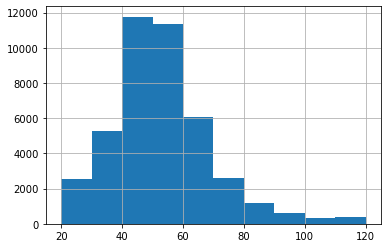

In [14]:
# Normalize biases
def normalize_bias(bias, min_norm, max_norm):
    min_real = np.min(bias)
    max_real = np.max(bias)
    return (bias - min_real) / (max_real - min_real) * (max_norm - min_norm) + min_norm

# Get line of best fit for all users
min_norm = 20
max_norm = 120
normalized_biases = normalize_bias(-svd.bi, min_norm, max_norm)
df_lindata = pd.DataFrame(
    [linregress(normalized_biases, row[1])._asdict() for row in df_md.iterrows()],
    df_md.index)

# Get user scores clipped to (20, 120)
user_scores = ((threshold - df_lindata['intercept']) / df_lindata['slope']).clip(min_norm, max_norm)
print(user_scores.describe())
user_scores.hist()

That feels better and more plausible for our training userbase! We have a lot of people of middling ability and fewer at either extreme, skewing toward those with less ability. This makes perfect sense for the demographic that was finding _Which Is English?_, a game aimed at non-native English speakers.

Now that we have our inputs and our outputs, the time has come to train our model...

## Training a model
### Decision trees
When it comes to selecting an algorithm to train, we want to keep in mind the nature of what we're trying to do. Is there an algorithm that serves the aim of building an adaptive test? An adaptive test's primary feature (besides that it works) is that it avoids giving the user _every single available test item_, which would be long and exhausting. Instead, an adaptive test should ask the minimum number of items required to be reasonably certain of the strength of the test-taker's latent ability. A linear regressor or neural network would certainly generate importance weights for all the items, and then we could present the items in order of their weights. But is there another model that has the property of choosing features by importance built into its basic structure? **Yes: decision trees.**

So the question becomes, **can we build a decision tree, deconstruct it, then turn each node into a test item?** It would certainly have adaptive qualities. Let's try it!

### A decision tree with items as nodes
First, we'll try asking scikit-learn to build a decision tree where each feature is an item. (Also, recall that we'll now be clipping our data to $[0.5, 1.0]$.) We'll try out different `min_samples_leaf` values to see if we can both maximize our model's score and reduce the depth of our tree.

For our metrics, we'll use:
- Model score, in this case R^2
- Mean error ("On average, how off is our predicted user score?")
- Max error ("What's the worst case scenario for a bad prediction?")
- Max tree depth ("How long will this test take?")

In [15]:
# Report metrics
def report_metrics(dt, X_test, y_test):
    print(f'model score: {dt.score(X_test, y_test)}')
    print(f'mean error: {mean_squared_error(y_test, dt.predict(X_test), squared=False)}')
    print(f'max error: {max_error(y_test, dt.predict(X_test))}')
    print(f'max tree depth: {dt.get_depth()}')

# Get training and testing data
X = df_md.clip(0.5) # Clip data minimum at pure guessing chance
y = user_scores
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

# Train model with grid search
cached_model_path = 'cached/model.joblib'
try:
    # Load model
    model = load(cached_model_path)
except:
    # Build and train model
    regressor = DecisionTreeRegressor(random_state=random_state)
    params = { 'min_samples_leaf': [1, 2, 4, 8, 16] }
    model = GridSearchCV(regressor, params).fit(X_train, y_train)
    
    # Save model
    dump(model, cached_model_path)
print(model.best_params_)
report_metrics(model.best_estimator_, X_test, y_test)

{'min_samples_leaf': 8}
model score: 0.9828859754248476
mean error: 2.1759116214049303
max error: 23.56745145230356
max tree depth: 18


Those are pretty good numbers! The model definitely seems usable, although the max error leaves something to be desired.

Of the given options, the optimal samples per leaf is eight, so we'll content ourselves with that.

Now let's sanity-check our model. What will a score look like for a test-taker who answers everything randomly (the total guesser) versus a tester who answers everything correctly? Ideally, their scores would be 20 (the minimum) and 120 (the maximum), respectively.

In [16]:
# Simulate random right and wrong answers
random_answers = np.random.randint(0, 2, X.shape[1])
print(f'random: {model.predict([random_answers])}')

# Simulate all correct answers
perfect_answers = np.ones(X.shape[1])
print(f'perfect: {model.predict([perfect_answers])}')

random: [92.15694424]
perfect: [120.]


While the perfect test result is 120 like we wanted, the random test result was unfortunately not 20; it turns out always to be a middling score. It looks as if we have a problem: **the decision tree takes each individual answer too seriously. Our data was trained on statistical chances, but our model was fed specific, binary answers.**

We need a way to make it so each node on the tree ends up with statistically significant input.

### A decision tree with buckets of items as nodes
One solution might be to cluster our items into buckets, meaning instead of asking a test-taker to answer a single item, we ask them to answer a bunch of similar items, which will give our predictive model inputs that are still discrete but more specific than just 0 or 1.

There are many approaches we could take to group items, including [truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), but that may be overkill when we can reasonably cluster items based on their bias instead.

To begin, we need to choose a bucket size. To prove out the idea, we just need a reasonable place to start. I like seven because it means the chances of guessing all right answers is less than 1% ($0.5^7 = 0.0078$). Let's see what our possible test inputs become with a bucket size of seven.

In [17]:
# Set bucket size
bucket_size = 7

# Calculate possible input values
for i in range(0, bucket_size + 1):
    print(f'{i} correct = {i / bucket_size}')

0 correct = 0.0
1 correct = 0.14285714285714285
2 correct = 0.2857142857142857
3 correct = 0.42857142857142855
4 correct = 0.5714285714285714
5 correct = 0.7142857142857143
6 correct = 0.8571428571428571
7 correct = 1.0


We'd be receiving one of eight possible values per node instead of two; that's much better.

Let's make our buckets. To do this, we'll sort our matrix data by item bias, take the maximum sample of users evenly divisible by seven, then group our items into buckets by taking the mean of their predictions.

In [18]:
# Randomly choose which item ids to keep and sort by bias
largest_sample_size = len(item_biases) - len(item_biases) % bucket_size
kept_item_ids = item_biases.sample(largest_sample_size, random_state=random_state).sort_values().index

# Split item ids into buckets
buckets = np.split(kept_item_ids, int(len(kept_item_ids) / bucket_size))
df_bucketed = pd.concat([df_md[bucket].mean(axis=1) for bucket in buckets], axis=1)
print(df_bucketed.shape)
df_bucketed.head()

(42200, 1931)


,0,1,2,3,4,5,6,7,8,9,...,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930
680,0.193613,0.262878,0.320998,0.333770,0.313280,0.351282,0.338707,0.341230,0.415754,0.356665,...,0.991979,0.994852,0.993831,0.989191,0.998904,0.999119,0.989181,0.998132,0.996326,0.999872
1140,0.000000,0.000000,0.018911,0.005905,0.031654,0.035325,0.025080,0.078633,0.050476,0.026151,...,0.579938,0.588444,0.582922,0.575385,0.592268,0.592067,0.590397,0.600336,0.590818,0.581868
684,0.201216,0.243090,0.257401,0.307879,0.287979,0.288481,0.317748,0.378559,0.327221,0.355542,...,0.895252,0.901247,0.908316,0.884718,0.900871,0.885401,0.882633,0.891561,0.879463,0.913809
743,0.226461,0.289766,0.308667,0.374955,0.363765,0.345437,0.347296,0.402635,0.399489,0.403678,...,0.966927,0.964677,0.967747,0.955450,0.959648,0.960985,0.970508,0.963610,0.983481,0.974768
1464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.064773,0.079326,0.066491,0.055174,0.060467,0.053007,0.050122,0.052596,0.072943,0.048837


Now we have 1,931 features for our decision tree to choose from instead of 13,517. Let's try training our model again.

In [19]:
# Get training and testing data
Xb = df_bucketed.clip(0.5) # Clip data minimum to pure guessing chance
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, y)

# Train model with grid search
cached_modelb_path = 'cached/modelb.joblib'
try:
    # Load model
    modelb = load(cached_modelb_path)
except:
    # Build and train model
    regressor = DecisionTreeRegressor(random_state=random_state)
    params = { 'min_samples_leaf': [1, 2, 4, 8, 16] }
    modelb = GridSearchCV(regressor, params).fit(Xb_train, yb_train)
    
    # Save model
    dump(modelb, cached_modelb_path)
print(modelb.best_params_)
report_metrics(modelb.best_estimator_, Xb_test, yb_test)

{'min_samples_leaf': 8}
model score: 0.994671508226265
mean error: 1.2072294364228606
max error: 12.4681381797636
max tree depth: 18


Now for our last sanity check: _Do random answers generate a low score?_ (Answering randomly to a bucket should generate a result of around 0.5, so we'll test a string of 0.5's).

In [20]:
# Simulate random right and wrong answers
random_answers_b = np.full(Xb.shape[1], 0.5)
print(f'random: {modelb.predict([random_answers_b])}')

# Simulate all correct answers
perfect_answers_b = np.ones(Xb.shape[1])
print(f'perfect: {modelb.predict([perfect_answers_b])}')

random: [20.]
perfect: [120.]


Excellent! Our random and perfect test-takers receive minimum and maximum scores, respectively. This is perhaps the decision tree we've seeking:

- Excellent R^2 score
- Mean error is within 1 point
- Max error is very reasonable
- Max test length = 7 * 20 = 140

140 questions may seem like a lot, but remember, these are binary questions with timeouts of ~10 seconds. Just to be safe, let's look at the descriptive stats for the various possible decision tree paths taken by our test users.

In [21]:
pd.DataFrame(modelb.best_estimator_.decision_path(Xb_test).todense()).sum(axis=1).describe()

count    10550.000000
mean        13.464834
std          1.599082
min          8.000000
25%         12.000000
50%         13.000000
75%         14.000000
max         19.000000
dtype: float64

It looks like our average test length will be ~13 nodes, and 7 * 13 = 91. 91 binary questions is still mentally taxing but not bad.

**Now, by [dissecting the decision tree's internal data](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html), we should be able to generate rules for an adaptive test, where each node takes the percent of correct answers from seven questions and chooses the next node based on its split threshold.**

Going a step further, we could implement a [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (or [extra trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)) regressor, deliver a multiple of the generated tests, and average the results—provided the test-delivery system has the logic to skip presenting duplicate items.

Once we turn the tree data into tests, we just need to build a front-end delivery system. The result of building that test is [here](https://mln-alpha.web.app/).